# Part 2. Prediction Task:
### Develop models to predict hospitalization mortality and visualize the results.


#### Mount to drive, import libraries and load datasets.

In [1]:
#Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Function to load datasets
def load_data():
    """Load data from CSV files and filter to smallest 1000 unique subject_ids with verification."""

    file_paths = {
        "Patient Feature Matrix": "/content/drive/MyDrive/technicaltaskdata/patient_feature_matrix.csv",
        "Feature Descriptions": "/content/drive/MyDrive/technicaltaskdata/feature_descriptions.csv",
        "Cohort": "/content/drive/MyDrive/technicaltaskdata/cohort.csv"
    }

    patient_features = pd.read_csv(file_paths["Patient Feature Matrix"])
    feature_descriptions = pd.read_csv(file_paths["Feature Descriptions"])
    cohort = pd.read_csv(file_paths["Cohort"])


    return patient_features, feature_descriptions, cohort

patient_features, feature_descriptions, cohort = load_data()



In [4]:
#Look through datasets
load_data()

(      subject_id death_in_stay  oxy_drop gender   age_in_days  \
 0             91          died    stable      F  29809.000000   
 1            106          died  oxy_drop      M  10358.333333   
 2            111      survived  oxy_drop      F  24388.979167   
 3            117          died  oxy_drop      F  18224.075000   
 4              3      survived  oxy_drop      M  27951.375000   
 ...          ...           ...       ...    ...           ...   
 3450       31983      survived  oxy_drop      M  30843.500000   
 3451       32506      survived    stable      F  23776.625000   
 3452       32513      survived    stable      F  28793.458333   
 3453       32408      survived    stable      M  19813.375000   
 3454       32417      survived    stable      M  20063.104167   
 
       icd9_ ADENOID CYSTIC CARCINOMA/SDA  icd9_ INTRACTABLE EPILEPSY/SDA  \
 0                                      0                               0   
 1                                      0           

#### Prepare the data for modeling. Handle missing values. Encode categorical features.


In [5]:
#Check for missing values
print("Missing values before handling:")
print(patient_features.isnull().sum().sum())

#Impute missing values with the mean for numerical columns
for col in patient_features.columns:
    if patient_features[col].dtype in ['int64', 'float64']:
        patient_features[col] = patient_features[col].fillna(patient_features[col].mean())

print("\nMissing values after handling:")
print(patient_features.isnull().sum().sum())


Missing values before handling:
0

Missing values after handling:
0


In [6]:
#Identify categorical features in the patient_features DataFrame
categorical_features = patient_features.select_dtypes(include=['object']).columns
print("\nCategorical features identified:")
print(categorical_features)



Categorical features identified:
Index(['death_in_stay', 'oxy_drop', 'gender'], dtype='object')


In [7]:
#Encode categorical features in patient_features DataFrame
patient_features_encoded = pd.get_dummies(patient_features, columns=categorical_features, dummy_na=False)


In [8]:
#Merge the processed patient_features DataFrame with the cohort DataFrame
merged_df = pd.merge(patient_features_encoded, cohort[['subject_id', 'death_in_stay']], on='subject_id', how='left')


#### Train machine learning model and deep learning models.

##### Logistic Regression Model

In [9]:
#Separate the features (X) and the target variable (y)
X = merged_df.drop(['subject_id', 'death_in_stay'], axis=1)
y = merged_df['death_in_stay']


In [10]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Machine learning model
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)

# Train the model
log_reg_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

##### Multilayer Perceptron Model

In [12]:
!pip install tensorflow

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(1, activation='sigmoid'))


mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

y_train_encoded = y_train.apply(lambda x: 1 if x == 'died' else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'died' else 0)

history = mlp_model.fit(X_train, y_train_encoded,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_test, y_test_encoded))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6646 - loss: 131.0609 - val_accuracy: 0.8177 - val_loss: 16.1296
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7433 - loss: 9.3503 - val_accuracy: 0.8234 - val_loss: 2.4040
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7568 - loss: 5.5813 - val_accuracy: 0.8148 - val_loss: 1.0877
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7586 - loss: 7.1256 - val_accuracy: 0.8205 - val_loss: 2.0490
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7394 - loss: 7.9771 - val_accuracy: 0.4935 - val_loss: 6.7572
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7836 - loss: 4.7957 - val_accuracy: 0.8162 - val_loss: 6.0084
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7852 - loss: 6.2845 - val_accuracy: 0.8148 - val_loss: 1.9465
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8127 - loss: 3.0526 - val_accuracy: 0.8234 - 

#### Evaluate performance of models.


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_pred = log_reg_model.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_precision = precision_score(y_test, log_reg_pred, pos_label='died')
log_reg_recall = recall_score(y_test, log_reg_pred, pos_label='died')
log_reg_f1 = f1_score(y_test, log_reg_pred, pos_label='died')

print("Logistic Regression Model Performance:")
print(f"Accuracy: {log_reg_accuracy:.4f}")
print(f"Precision: {log_reg_precision:.4f}")
print(f"Recall: {log_reg_recall:.4f}")
print(f"F1-score: {log_reg_f1:.4f}")


mlp_pred_prob = mlp_model.predict(X_test)
mlp_pred_binary = (mlp_pred_prob > 0.5).astype(int)

mlp_accuracy = accuracy_score(y_test_encoded, mlp_pred_binary)
mlp_precision = precision_score(y_test_encoded, mlp_pred_binary)
mlp_recall = recall_score(y_test_encoded, mlp_pred_binary)
mlp_f1 = f1_score(y_test_encoded, mlp_pred_binary)

print("\nDeep Learning Model Performance:")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1-score: {mlp_f1:.4f}")

Logistic Regression Model Performance:
Accuracy: 0.8307
Precision: 0.5818
Recall: 0.2540
F1-score: 0.3536
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Deep Learning Model Performance:
Accuracy: 0.6469
Precision: 0.3275
Recall: 0.8889
F1-score: 0.4786


#### Visualize results



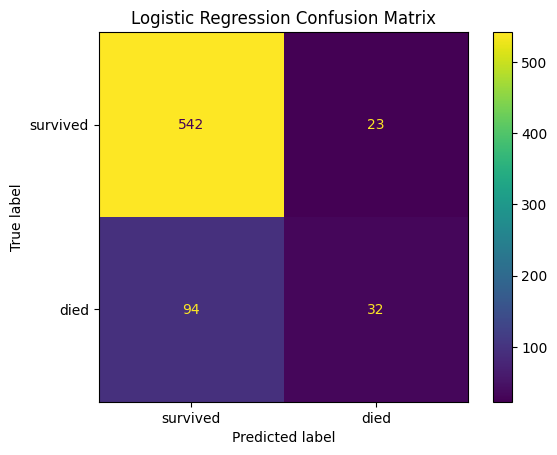

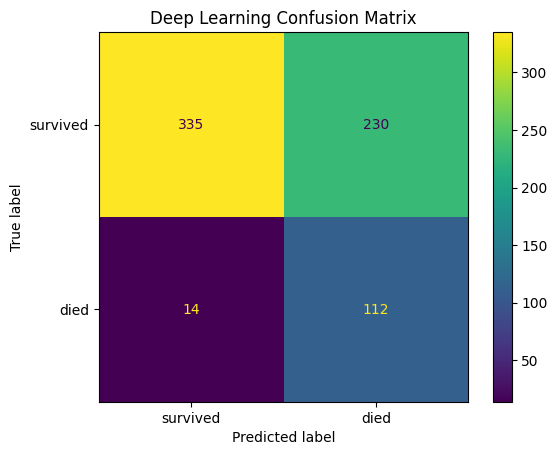

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot confusion matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, log_reg_pred, labels=['survived', 'died'])
log_reg_disp = ConfusionMatrixDisplay(confusion_matrix=log_reg_cm, display_labels=['survived', 'died'])
log_reg_disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Compute and plot confusion matrix for MLP
mlp_cm = confusion_matrix(y_test_encoded, mlp_pred_binary, labels=[0, 1])
mlp_disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=['survived', 'died'])
mlp_disp.plot()
plt.title("Deep Learning Confusion Matrix")
plt.show()

#### Explanation methods and results

**1. Data Loading and Initial Inspection:** Before analysis or modelling, it is possible to understand the data's columns, format, and possible problems by loading and inspecting the data.

**2. Data Preparation and Preprocessing:**
- **Handling Missing Values:** First looked for missing values in the patient_features DataFrame then imputed the missing numerical values using the mean of their corresponding columns, if dataset had missing values.
- **Encoding Categorical Features:** Categorical features were one-hot encoded using pd.get_dummies to convert them into a numerical format suitable for machine learning models.
- **Data Merging:** To include the target variable (death_in_stay) in the main DataFrame, the encoded patient features were merged with the cohort DataFrame using subject_id.
- **Feature-Target Split:** The merged DataFrame was split into features (X) and the target variable (y) and the.  subject_id and the original death_in_stay columns were dropped from the features.
- **Train-Test Split:** The data was split into training and testing sets using train_test_split with a test_size of 0.2 (20% for testing) and random_state=42 for reproducibility. stratify=y was used to ensure that the proportion of the target variable (death_in_stay) is the same in both the training and testing sets.
**Reasoning:* Preparing the data for machine learning models requires data preparation.  Managing missing values guarantees error-free data processing by the models.  Categorical features are transformed into a numerical format that is understandable by the majority of algorithms by encoding.  To assess the model's performance on unknown data and avoid overfitting, the data must be divided into training and testing sets.

**3. Model Training:**
- **Logistic Regression:** The X_trainand y_train data were used to create and train a Logistic Regression model.  To give the model additional time to converge, max_iter=1000 was specified.
- **Deep Learning Model (MLP):** TensorFlow/Keras was used to build a basic feedforward neural network (MLP).  It was composed of an output layer with sigmoid activation for binary classification and two dense layers with ReLU activation.  Binary cross-entropy loss and the Adam optimizer were used to compile the model.  Prior to deep learning model training, the target variable {y` was encoded into numerical labels (0 and 1).  The encoded training data was then used to train the model.
**Reasoning:* To compare the performance of two distinct model types on this prediction task, a deep learning model (MLP) and a conventional machine learning model (Logistic Regression) were used.  A deep learning model can identify more intricate non-linear associations in the data, whereas logistic regression is a straightforward yet effective linear model.

**4. Model Evaluation:**
- The trained models were used to make predictions on the test set (X_test).
- The performance of both models was evaluated using several metrics: accuracy, precision, recall, and F1-score. These metrics provide a comprehensive view of the models' performance, especially for imbalanced datasets.
- Confusion matrices were generated and plotted for both models to visually represent their performance, showing the number of true positives, true negatives, false positives, and false negatives.
**Reasoning:* To evaluate the models' capacity for generalization, a different test set must be used.  A more comprehensive view of the models' advantages and disadvantages can be obtained by utilizing a variety of evaluation measures.  A visual breakdown of the prediction results is provided by confusion matrices, which can be useful in identifying areas in which the models are failing.

**Summary of Findings:**

Key trade-offs between the Deep Learning (DL) and Logistic Regression (LR) models for inpatient mortality prediction are shown by the performance measures.  The LR model produces fewer false positive predictions (i.e., wrongly labelling survivors as deceased) due to its better accuracy (0.8307 vs. 0.6469) and precision (0.5818 vs. 0.3275).  Because of this, LR is more suited for therapeutic decisions that need a high degree of confidence in positive predictions, such allocating resources to high-risk patients or avoiding needless procedures.  However, if the dataset is unbalanced (e.g., few deaths), accuracy should be taken with caution.  Bias towards the majority class (survivors) may be a contributing factor in LR's high accuracy.

The DL model, on the other hand, has superior recall (0.8889 vs. 0.2540), capturing almost all cases of actual mortality while reducing false negatives.  Because of this, DL is superior in situations when it is far riskier to miss a true positive (such as failing to predict death) than to occasionally raise false alarms. Although only 25.1% of the "death" predictions made by the DL model are accurate due to its low precision, this trade-off might be acceptable in triage systems where missed deaths, or false negatives, are morally or legally unacceptable, even if it means more false alerts (e.g., sepsis detection or critical care early-warning systems).

The choice between models ultimately depends on the clinical priority: DL for sensitivity (ensuring no at-risk patient is overlooked) or LR for specificity (reducing false alarms), even though the DL model has a slightly higher F1-score (0.4786 vs. 0.3536), reflecting a better balance between precision and recall.

**Futher improvement:**

Based on the existing implementation, the results indicate that the Logistic Regression model is a better option for this purpose.  To enhance the deep learning model's performance, additional effort might entail adjusting the hyperparameters for both models, investigating various deep learning architectures, and possibly adding more feature engineering.
